# LCRTest1

## Setup and Data

In [13]:
# Imports functions into the program
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#These are imported specifically for the use of the histogram.
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib import gridspec
from scipy import stats

#Imported for categorization of the Sources
from fractional_variability import fvar
from fermi_catalog import select_bll, select_fsrq, select_bcu

In [14]:
table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",", na_filter=True)
readed = readed.fillna(-3333)

cadence = 'daily'
cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]
#cadence_df.loc[cadence_df['ts2'] <= 9., 'photon_flux2'] = -3333
cadence_df.loc[cadence_df['ts2'] <= 4., ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set as -3333 all points with an error larger than the flux
cadence_df.loc[cadence_df['photon_flux_error2'] > cadence_df['photon_flux2'], ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set cuts to remove possible outliers due to bad convergence of a bin
cadence_df.loc[cadence_df['photon_flux2'] > 1e-4, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[cadence_df['photon_flux2'] < 1e-10, ['photon_flux2', 'photon_flux_error2']] = -3333
#print(cadence_df)

TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]

In [15]:
# This function takes the dataframe of sources of variable objects, and the name of a source.
# It will sort through every entry in the dataframe, and detect consecutive entries with a flux level higher than the average.
# It counts the duration of these flaring states, and notes them in an array 'final', which it returns upon completion.
def flare_detector(name,met,flux,eflux):
    final = [0,0,0]
    k=0
    temp =[]
    temp_err=[]
    duration = []
    average=[]
    # This section is for setting up our dataframes which will be used in the following loop.
    # We primarily are eliminating outliers and NaN values that were marked with -3333.
    #sourcematrix = dataframe.loc[dataframe['source_name'] == name].reset_index(drop=True)
    fluxmatrix = flux
    averageflux = np.mean(fluxmatrix)
    errormatrix = eflux
    boolmatrix = fluxmatrix/averageflux > 1  
    boolmatrix = boolmatrix
    for i in range(len(fluxmatrix)):
        # If the flux value for index i is greater than the average, then this condition is met.
        if boolmatrix[i] == True:
            temp.append(fluxmatrix[i])
            temp_err.append(errormatrix[i])
        # If the flux value is not above average, and there are values stored in the temp array, we gather them and send them to 'final'.
        elif len(temp) != 0:
            if i != 0:
                duration = ((len(temp)))
                average = np.nanmean(temp)
                error = ((sum(k*k for k in temp_err))**0.5)*(1/(len(temp_err)))
                temp = []
                temp_err = []
                final = np.vstack([final,[duration,average,error]])
        # Otherwise, we add a row of 0's to show that the source has no flaring states.
        else:
            final = np.vstack([final,[0,0,0]])


    return final

In [16]:
# These three loops will run the flare_detector function for each category of blazar.
import glob
import numpy as np

cadence='daily'
#cadence='weekly'
#cadence='monthly'

fsrq_files=glob.glob('./simulated_LC_FSRQ_'+cadence+'_white_noise/sim_lc*.dat')

fsrq_flares = [0,0,0]
for i,file in enumerate(fsrq_files[0:573]):
    #print(i,name) 
    #print(flare_detector(name,cadence_df))
    name=str(i)

    data_sim=np.loadtxt(file)
    met_sim=data_sim[:,0]
    flux_sim=data_sim[:,1]
    eflux_sim=data_sim[:,2]
    fsrq_flares = np.vstack([fsrq_flares,flare_detector(name,met_sim,flux_sim,eflux_sim)])

bll_files=glob.glob('./simulated_LC_BLL_'+cadence+'_white_noise/sim_lc*.dat')

bll_flares = [0,0,0]
for i,file in enumerate(bll_files[0:478]):
    #print(i,name) 
    #print(flare_detector(name,cadence_df))
    name=str(i)

    data_sim=np.loadtxt(file)
    met_sim=data_sim[:,0]
    flux_sim=data_sim[:,1]
    eflux_sim=data_sim[:,2]
    bll_flares = np.vstack([bll_flares,flare_detector(name,met_sim,flux_sim,eflux_sim)])

bcu_files=glob.glob('./simulated_LC_BCU_'+cadence+'_white_noise/sim_lc*.dat')

bcu_flares = [0,0,0]
for i,file in enumerate(bcu_files[0:365]):
    #print(i,name) 
    #print(flare_detector(name,cadence_df))
    name=str(i)

    data_sim=np.loadtxt(file)
    met_sim=data_sim[:,0]
    flux_sim=data_sim[:,1]
    eflux_sim=data_sim[:,2]
    bcu_flares = np.vstack([bcu_flares,flare_detector(name,met_sim,flux_sim,eflux_sim)])

#remove=[]
#for i in range(len(fsrq_flares)):
#    if fsrq_flares[i,0]>=100 or fsrq_flares[i,1]>=2e6:
#        remove.append(i)
#
#fsrq_flares=np.delete(fsrq_flares,remove,axis=0)
#
#for i in range(len(fsrq_flares)):
#    if fsrq_flares[i,0]>=30:
#        fsrq_flares[i,0]=fsrq_flares[i,0]*0.5
#        fsrq_flares[i,1]=fsrq_flares[i,1]*0.5
#        fsrq_flares[i,2]=fsrq_flares[i,2]*0.5
#
#for i in range(len(fsrq_flares)):
#    if fsrq_flares[i,0]>=70:
#        fsrq_flares[i,0]=fsrq_flares[i,0]*0.5
#        fsrq_flares[i,1]=fsrq_flares[i,1]*0.5
#        fsrq_flares[i,2]=fsrq_flares[i,2]*0.5
#
#for i in range(len(fsrq_flares)):
#    if fsrq_flares[i,0]>15 and fsrq_flares[i,0]<30:
#        fsrq_flares[i,0]=fsrq_flares[i,0]*0.5
#        fsrq_flares[i,1]=fsrq_flares[i,1]*0.5
#        fsrq_flares[i,2]=fsrq_flares[i,2]*0.5

total_flares=np.vstack([fsrq_flares,bll_flares,bcu_flares])

<function matplotlib.pyplot.show(close=None, block=None)>

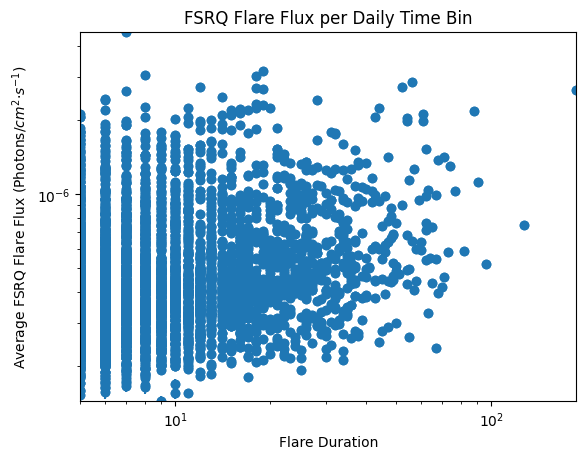

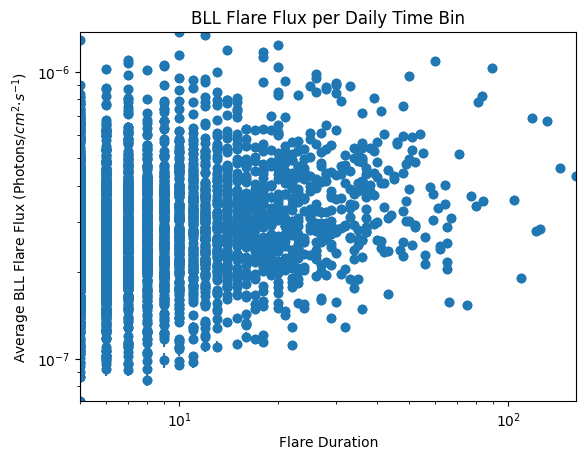

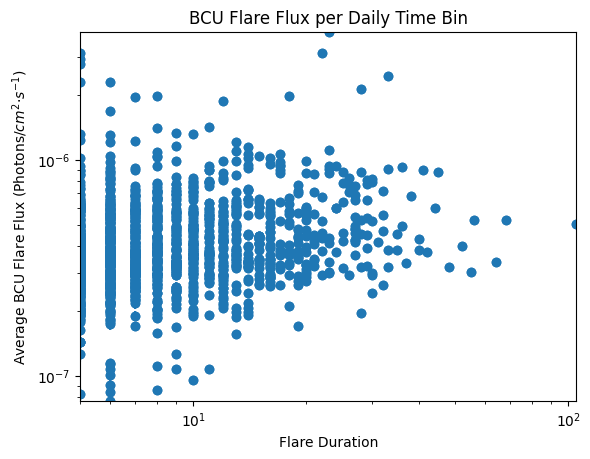

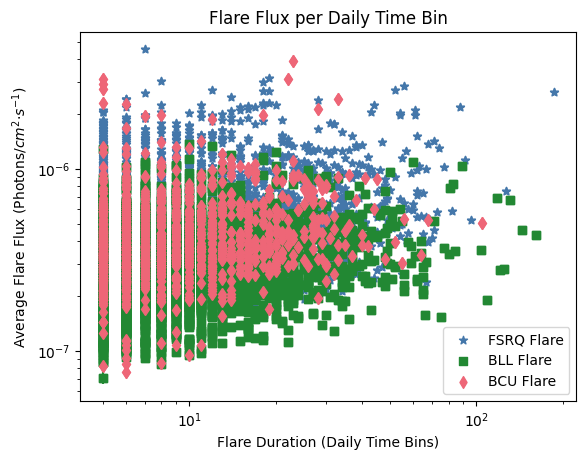

In [17]:

# This section makes four Average Flux vs Duration plots: one for each category of blazars, and a final plot for all three together.

fsrq_plot = fsrq_flares[fsrq_flares[:,0]>=5]
fsrq_ysize = fsrq_flares.size
fsrq_x = fsrq_plot[:,0]
fsrq_xmin = min(fsrq_x)
fsrq_xmax = max(fsrq_x)
fsrq_y = fsrq_plot[:,1]
fsrq_ymin = min(fsrq_y)
fsrq_ymax = max(fsrq_y)
fsrq_err=fsrq_plot[:,2]
plt.ylim([fsrq_ymin,fsrq_ymax])
plt.xlim([fsrq_xmin,fsrq_xmax])
plt.scatter(fsrq_x,fsrq_y)
plt.errorbar(fsrq_x,fsrq_y,yerr=fsrq_err,fmt = 'o')
plt.ylabel('Average FSRQ Flare Flux (Photons/$cm^2\u22c5s^{-1}$)')
plt.xlabel('Flare Duration')
plt.title('FSRQ Flare Flux per Daily Time Bin')
plt.yscale('log')
plt.xscale('log')
plt.figure()

bll_plot = bll_flares[bll_flares[:,0]>=5]
bll_ysize = bll_flares.size
bll_x = bll_plot[:,0]
bll_xmin = min(bll_x)
bll_xmax = max(bll_x)
bll_y = bll_plot[:,1]
bll_ymin = min(bll_y)
bll_ymax = max(bll_y)
bll_err=bll_plot[:,2]
plt.ylim([bll_ymin,bll_ymax])
plt.xlim([bll_xmin,bll_xmax])
plt.scatter(bll_x,bll_y)
plt.errorbar(bll_x,bll_y,yerr=bll_err,fmt = 'o')
plt.ylabel('Average BLL Flare Flux (Photons/$cm^2\u22c5s^{-1}$)')
plt.xlabel('Flare Duration')
plt.title('BLL Flare Flux per Daily Time Bin')
plt.yscale('log')
plt.xscale('log')
plt.figure()

bcu_plot = bcu_flares[bcu_flares[:,0]>=5]
ysize = bcu_flares.size
bcu_x = bcu_plot[:,0]
bcu_xmin = min(bcu_x)
bcu_xmax = max(bcu_x)
bcu_y = bcu_plot[:,1]
bcu_ymin = min(bcu_y)
bcu_ymax = max(bcu_y)
bcu_err = bcu_plot[:,2]
plt.ylim([bcu_ymin,bcu_ymax])
plt.xlim([bcu_xmin,bcu_xmax])
plt.scatter(bcu_x,bcu_y)
plt.errorbar(bcu_x,bcu_y,yerr=bcu_err,fmt = 'o')
plt.ylabel('Average BCU Flare Flux (Photons/$cm^2\u22c5s^{-1}$)')
plt.xlabel('Flare Duration')
plt.title('BCU Flare Flux per Daily Time Bin')
plt.yscale('log')
plt.xscale('log')
plt.figure()

#Combined Graphic
plt.scatter(fsrq_x,fsrq_y,marker = '*',color='#4477AA',label='FSRQ Flare')
plt.errorbar(fsrq_x,fsrq_y,yerr=fsrq_err,fmt = '*',color='#4477AA')
plt.scatter(bll_x,bll_y,marker = 's',color='#228833',label='BLL Flare')
plt.errorbar(bll_x,bll_y,yerr=bll_err,fmt = 's',color='#228833')
plt.scatter(bcu_x,bcu_y,marker = 'd',color='#EE6677',label='BCU Flare')
plt.errorbar(bcu_x,bcu_y,yerr=bcu_err,fmt = 'd',color='#EE6677')
plt.legend()
plt.ylabel('Average Flare Flux (Photons/$cm^2\u22c5s^{-1}$)')
plt.xlabel('Flare Duration (Daily Time Bins)')
plt.title('Flare Flux per Daily Time Bin')
plt.yscale('log')
plt.xscale('log')
#plt.xlim(10,40)
#plt.ylim(0.0000001,0.000002)
plt.show
#Flux is 1/cm^2*s


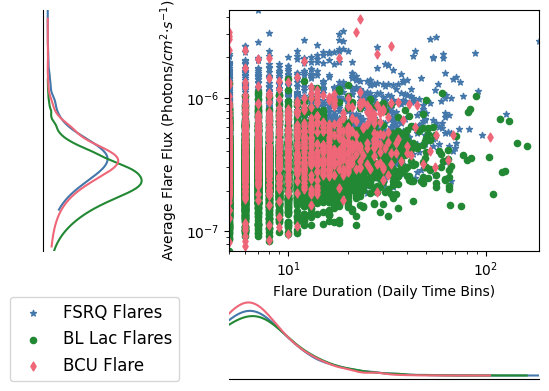

In [18]:
label = ['FSRQ Flares','BL Lac Flares','BCU Flare'] # List of labels for categories
cl = ['#4477AA','#228833','#EE6677'] # List of colours for categories
categories = len(label)


# Set up 4 subplots as axis objects using GridSpec:
gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,1])
# Add space between scatter plot and KDE plots to accommodate axis labels:
gs.update(hspace=0.3, wspace=0.4)

# Set background canvas colour to White instead of grey default
fig = plt.figure()
fig.patch.set_facecolor('white')

ax = plt.subplot(gs[0,1]) # Instantiate scatter plot area and axis range
ax.set_xlim(min(fsrq_xmin,bll_xmin,bcu_xmin), max(fsrq_xmax,bll_xmax,bcu_xmax))
ax.set_ylim(min(fsrq_ymin,bll_ymin,bcu_ymin), max(fsrq_ymax,bll_ymax,bcu_ymax))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Flare Duration (Daily Time Bins)')
ax.set_ylabel('Average Flare Flux (Photons/$cm^2\u22c5s^{-1}$)')

axl = plt.subplot(gs[0,0], sharey=ax) # Instantiate left KDE plot area
axl.get_xaxis().set_visible(False) # Hide tick marks and spines
axl.get_yaxis().set_visible(False)
axl.spines["right"].set_visible(False)
axl.spines["top"].set_visible(False)
axl.spines["bottom"].set_visible(False)

axb = plt.subplot(gs[1,1], sharex=ax) # Instantiate bottom KDE plot area
axb.get_xaxis().set_visible(False) # Hide tick marks and spines
axb.get_yaxis().set_visible(False)
axb.spines["right"].set_visible(False)
axb.spines["top"].set_visible(False)
axb.spines["left"].set_visible(False)

axc = plt.subplot(gs[1,0]) # Instantiate legend plot area
axc.axis('off') # Hide tick marks and spines

# Plot data for each categorical variable as scatter and marginal KDE plots:
#FSRQ PLOT
ax.scatter(fsrq_x, fsrq_y, marker = '*', color=cl[0], label=label[0], s=20, edgecolor= cl[0])    
kde = stats.gaussian_kde(fsrq_x)
fsrq_xx = np.linspace(fsrq_xmin,fsrq_xmax,1000)
axb.plot(fsrq_xx,kde(fsrq_xx), color=cl[0],)
kde = stats.gaussian_kde(fsrq_y)
fsrq_yy = np.linspace(fsrq_ymin,fsrq_ymax,1000)
axl.plot(kde(fsrq_yy), fsrq_yy, color=cl[0],)

#BLL PLOT
ax.scatter(bll_x,bll_y, color=cl[1], label=label[1], s=20, edgecolor= cl[1])
kde = stats.gaussian_kde(bll_x)
bll_xx = np.linspace(bll_xmin,bll_xmax,1000)
axb.plot(bll_xx, kde(bll_xx), color=cl[1])
kde = stats.gaussian_kde(bll_y)
bll_yy = np.linspace(bll_ymin,bll_ymax,1000)
axl.plot(kde(bll_yy), bll_yy, color=cl[1])

#BCU PLOT
ax.scatter(bcu_x,bcu_y, marker = 'd', color=cl[2], label=label[2], s=20, edgecolor= cl[2])
kde = stats.gaussian_kde(bcu_x)
bcu_xx = np.linspace(bcu_xmin,bcu_xmax,1000)
axb.plot(bcu_xx, kde(bcu_xx), color=cl[2])
kde = stats.gaussian_kde(bcu_y)
bcu_yy = np.linspace(bcu_ymin,bcu_ymax,1000)
axl.plot(kde(bcu_yy), bcu_yy, color=cl[2])

# Copy legend object from scatter plot to lower left subplot and display:
# NB 'scatterpoints = 1' customises legend box to show only 1 handle (icon) per label 
handles, labels = ax.get_legend_handles_labels()
axc.legend(handles, labels, scatterpoints = 1, loc = 'center', fontsize = 12)
plt.show()

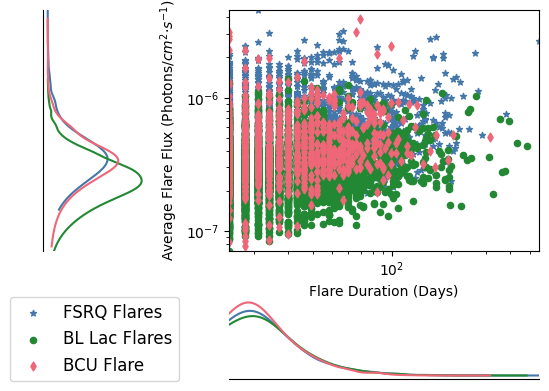

In [19]:
# Graph modified for 3 Day Daily Cadence
label = ['FSRQ Flares','BL Lac Flares','BCU Flare'] # List of labels for categories
cl = ['#4477AA','#228833','#EE6677'] # List of colours for categories
categories = len(label)


# Set up 4 subplots as axis objects using GridSpec:
gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,1])
# Add space between scatter plot and KDE plots to accommodate axis labels:
gs.update(hspace=0.3, wspace=0.4)

# Set background canvas colour to White instead of grey default
fig = plt.figure()
fig.patch.set_facecolor('white')

ax = plt.subplot(gs[0,1]) # Instantiate scatter plot area and axis range
ax.set_xlim(min(fsrq_xmin,bll_xmin,bcu_xmin)*3, max(fsrq_xmax,bll_xmax,bcu_xmax)*3)
ax.set_ylim(min(fsrq_ymin,bll_ymin,bcu_ymin), max(fsrq_ymax,bll_ymax,bcu_ymax))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Flare Duration (Days)')
ax.set_ylabel('Average Flare Flux (Photons/$cm^2\u22c5s^{-1}$)')

axl = plt.subplot(gs[0,0], sharey=ax) # Instantiate left KDE plot area
axl.get_xaxis().set_visible(False) # Hide tick marks and spines
axl.get_yaxis().set_visible(False)
axl.spines["right"].set_visible(False)
axl.spines["top"].set_visible(False)
axl.spines["bottom"].set_visible(False)

axb = plt.subplot(gs[1,1], sharex=ax) # Instantiate bottom KDE plot area
axb.get_xaxis().set_visible(False) # Hide tick marks and spines
axb.get_yaxis().set_visible(False)
axb.spines["right"].set_visible(False)
axb.spines["top"].set_visible(False)
axb.spines["left"].set_visible(False)

axc = plt.subplot(gs[1,0]) # Instantiate legend plot area
axc.axis('off') # Hide tick marks and spines

# Plot data for each categorical variable as scatter and marginal KDE plots:
#FSRQ PLOT
ax.scatter(fsrq_x*3, fsrq_y, marker = '*', color=cl[0], label=label[0], s=20, edgecolor= cl[0])    
kde = stats.gaussian_kde(fsrq_x*3)
fsrq_xx = np.linspace(fsrq_xmin,fsrq_xmax,1000)*3
axb.plot(fsrq_xx,kde(fsrq_xx), color=cl[0],)
kde = stats.gaussian_kde(fsrq_y)
fsrq_yy = np.linspace(fsrq_ymin,fsrq_ymax,1000)
axl.plot(kde(fsrq_yy), fsrq_yy, color=cl[0],)

#BLL PLOT
ax.scatter(bll_x*3,bll_y, color=cl[1], label=label[1], s=20, edgecolor= cl[1])
kde = stats.gaussian_kde(bll_x*3)
bll_xx = np.linspace(bll_xmin,bll_xmax,1000)*3
axb.plot(bll_xx, kde(bll_xx), color=cl[1])
kde = stats.gaussian_kde(bll_y)
bll_yy = np.linspace(bll_ymin,bll_ymax,1000)
axl.plot(kde(bll_yy), bll_yy, color=cl[1])

#BCU PLOT
ax.scatter(bcu_x*3,bcu_y, marker = 'd', color=cl[2], label=label[2], s=20, edgecolor= cl[2])
kde = stats.gaussian_kde(bcu_x*3)
bcu_xx = np.linspace(bcu_xmin,bcu_xmax,1000)*3
axb.plot(bcu_xx, kde(bcu_xx), color=cl[2])
kde = stats.gaussian_kde(bcu_y)
bcu_yy = np.linspace(bcu_ymin,bcu_ymax,1000)
axl.plot(kde(bcu_yy), bcu_yy, color=cl[2])

# Copy legend object from scatter plot to lower left subplot and display:
# NB 'scatterpoints = 1' customises legend box to show only 1 handle (icon) per label 
handles, labels = ax.get_legend_handles_labels()
axc.legend(handles, labels, scatterpoints = 1, loc = 'center', fontsize = 12)
plt.show()

In [20]:
fsrq_filtered = fsrq_flares[fsrq_flares[:,0] != 0]
fsrq_flareduration = fsrq_filtered[:,0]
fsrq_flareflux = fsrq_filtered[:,1]
fsrq_flareduration=np.asarray(fsrq_flareduration,dtype='float64')
fsrq_flareflux=np.asarray(fsrq_flareflux,dtype='float64')
fsrq_fluence = np.multiply(fsrq_flareflux,fsrq_flareduration)*(3*24*60*60)
#pd.DataFrame(fsrq_flareduration)
#pd.DataFrame(fsrq_flareflux)
pd.DataFrame(fsrq_fluence)
fsrq_fluencecount = np.zeros(len(fsrq_fluence))
fsrq_fluencethresholds=sorted(fsrq_fluence)
for i in range(0,len(fsrq_fluence)):
    fsrq_fluencecount[i]=len(fsrq_fluence[fsrq_fluence>fsrq_fluencethresholds[i]])
pd.DataFrame(fsrq_fluencethresholds)

bll_filtered = bll_flares[bll_flares[:,0] != 0]
bll_flareduration = bll_filtered[:,0]
bll_flareflux = bll_filtered[:,1]
bll_flareduration=np.asarray(bll_flareduration,dtype='float64')
bll_flareflux=np.asarray(bll_flareflux,dtype='float64')
bll_fluence = np.multiply(bll_flareflux,bll_flareduration)*(3*24*60*60)
#pd.DataFrame(bll_flareduration)
#pd.DataFrame(bll_flareflux)
pd.DataFrame(bll_fluence)
bll_fluencecount = np.zeros(len(bll_fluence))
bll_fluencethresholds=sorted(bll_fluence)
for i in range(0,len(bll_fluence)):
    bll_fluencecount[i]=len(bll_fluence[bll_fluence>bll_fluencethresholds[i]])
pd.DataFrame(bll_fluencethresholds)


bcu_filtered = bcu_flares[bcu_flares[:,0] != 0]
bcu_flareduration = bcu_filtered[:,0]
bcu_flareflux = bcu_filtered[:,1]
bcu_flareduration=np.asarray(bcu_flareduration,dtype='float64')*(3*24*60*60)
bcu_flareflux=np.asarray(bcu_flareflux,dtype='float64')
bcu_fluence = np.multiply(bcu_flareflux,bcu_flareduration)
#pd.DataFrame(bcu_flareduration)
#pd.DataFrame(bcu_flareflux)
pd.DataFrame(bcu_fluence)
bcu_fluencecount = np.zeros(len(bcu_fluence))
bcu_fluencethresholds=sorted(bcu_fluence)
for i in range(0,len(bcu_fluence)):
    bcu_fluencecount[i]=len(bcu_fluence[bcu_fluence>bcu_fluencethresholds[i]])
pd.DataFrame(bcu_fluencethresholds)


total_filtered = total_flares[total_flares[:,0] != 0]
total_flareduration = total_filtered[:,0]
total_flareflux = total_filtered[:,1]
total_flareduration=np.asarray(total_flareduration,dtype='float64')
total_flareflux=np.asarray(total_flareflux,dtype='float64')
total_fluence = np.multiply(total_flareflux,total_flareduration)*(3*24*60*60)
#pd.DataFrame(bcu_flareduration)
#pd.DataFrame(bcu_flareflux)
pd.DataFrame(total_fluence)
total_fluencecount = np.zeros(len(total_fluence))
total_fluencethresholds=sorted(total_fluence)
for i in range(0,len(total_fluence)):
    total_fluencecount[i]=len(total_fluence[total_fluence>total_fluencethresholds[i]])
pd.DataFrame(total_fluencethresholds)

,0
0,0.011922
1,0.014728
2,0.014896
3,0.015177
4,0.015486
...,...
41115,33.501609
41116,36.820038
41117,41.356157
41118,49.679366


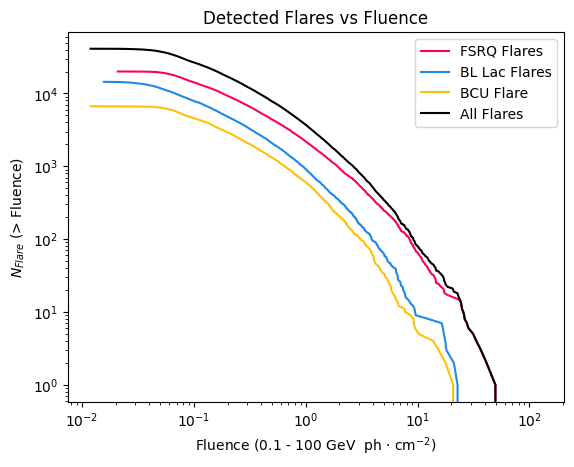

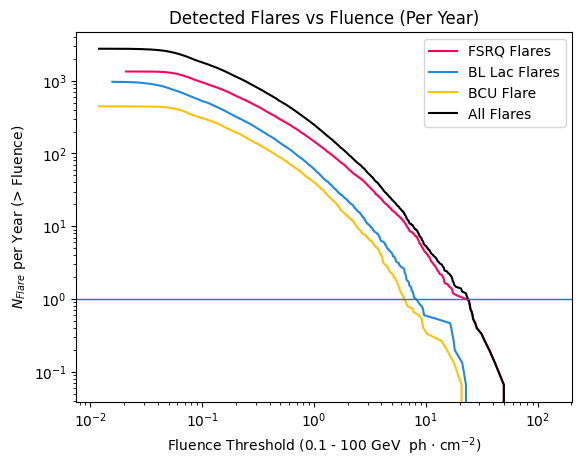

In [21]:
label = ['FSRQ Flares','BL Lac Flares','BCU Flare','All Flares'] # List of labels for categories
cl = ['#FF005D','#1E88E5','#FFC107','000000'] # List of colours for categories
plt.figure()
plt.plot(fsrq_fluencethresholds,fsrq_fluencecount, color=cl[0], label=label[0])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/cm^2)')

plt.plot(bll_fluencethresholds,bll_fluencecount, color=cl[1], label=label[1])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

plt.plot(bcu_fluencethresholds,bcu_fluencecount, color=cl[2], label=label[2])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

plt.plot(total_fluencethresholds,total_fluencecount, color=cl[3], label=label[3])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('$N_{Flare}$ (> Fluence)')
plt.xlabel('Fluence (0.1 - 100 GeV  ph \u22c5 cm$^{-2}$)')
plt.title('Detected Flares vs Fluence')


plt.legend()

plt.figure()
label = ['FSRQ Flares','BL Lac Flares','BCU Flare','All Flares'] # List of labels for categories
cl = ['#FF005D','#1E88E5','#FFC107','000000'] # List of colours for categories

plt.plot(fsrq_fluencethresholds,fsrq_fluencecount/15, color=cl[0], label=label[0])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photns/cm^2)')

plt.plot(bll_fluencethresholds,bll_fluencecount/15, color=cl[1], label=label[1])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

plt.plot(bcu_fluencethresholds,bcu_fluencecount/15, color=cl[2], label=label[2])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

plt.plot(total_fluencethresholds,total_fluencecount/15, color=cl[3], label=label[3])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('$N_{Flare}$ per Year (> Fluence)')
plt.xlabel('Fluence Threshold (0.1 - 100 GeV  ph \u22c5 cm$^{-2}$)')
plt.title('Detected Flares vs Fluence (Per Year)')
plt.hlines(1,10**-3,10**3,linewidth=1)

plt.legend()

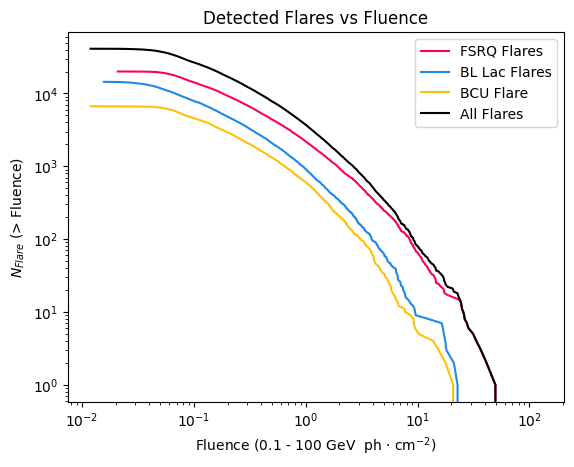

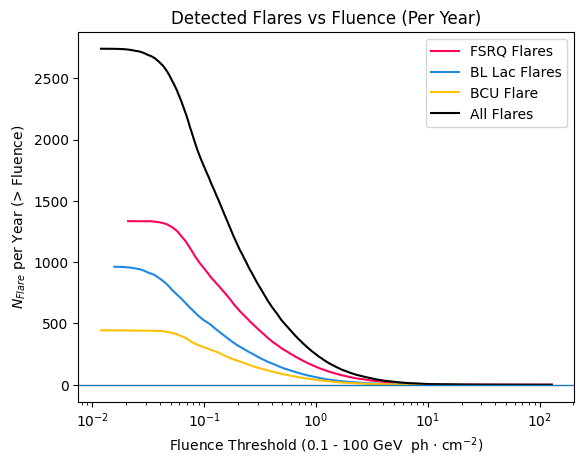

In [22]:
label = ['FSRQ Flares','BL Lac Flares','BCU Flare','All Flares'] # List of labels for categories
cl = ['#FF005D','#1E88E5','#FFC107','000000'] # List of colours for categories
plt.figure()
plt.plot(fsrq_fluencethresholds,fsrq_fluencecount, color=cl[0], label=label[0])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/cm^2)')

plt.plot(bll_fluencethresholds,bll_fluencecount, color=cl[1], label=label[1])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

plt.plot(bcu_fluencethresholds,bcu_fluencecount, color=cl[2], label=label[2])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

plt.plot(total_fluencethresholds,total_fluencecount, color=cl[3], label=label[3])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('$N_{Flare}$ (> Fluence)')
plt.xlabel('Fluence (0.1 - 100 GeV  ph \u22c5 cm$^{-2}$)')
plt.title('Detected Flares vs Fluence')


plt.legend()

plt.figure()
label = ['FSRQ Flares','BL Lac Flares','BCU Flare','All Flares'] # List of labels for categories
cl = ['#FF005D','#1E88E5','#FFC107','000000'] # List of colours for categories

plt.plot(fsrq_fluencethresholds,fsrq_fluencecount/15, color=cl[0], label=label[0])
#plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photns/cm^2)')

plt.plot(bll_fluencethresholds,bll_fluencecount/15, color=cl[1], label=label[1])
#plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

plt.plot(bcu_fluencethresholds,bcu_fluencecount/15, color=cl[2], label=label[2])
#plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

plt.plot(total_fluencethresholds,total_fluencecount/15, color=cl[3], label=label[3])
#plt.yscale('log')
plt.xscale('log')
plt.ylabel('$N_{Flare}$ per Year (> Fluence)')
plt.xlabel('Fluence Threshold (0.1 - 100 GeV  ph \u22c5 cm$^{-2}$)')
plt.title('Detected Flares vs Fluence (Per Year)')
plt.hlines(1,10**-3,10**3,linewidth=1)

plt.legend()